In [1]:
import zipfile
import os


In [2]:
zip_file_path = 'Dataset Brain Tumor.zip'  # Replace with your file's name
extract_dir = 'Dataset Brain Tumor'  # Replace with the desired extraction directory


In [3]:
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)


In [4]:
extracted_files = os.listdir(extract_dir)
print(extracted_files)

['Dataset Brain Tumor', 'vi.py']


In [7]:
!pip install tensorflow


Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 436.2 kB/s eta 0:00:00a 0:00:01
  Attempting uninstall: keras
    Found existing installation: Keras 2.2.4
    Uninstalling Keras-2.2.4:
      Successfully uninstalled Keras-2.2.4


In [10]:
!pip install keras


Defaulting to user installation because normal site-packages is not writeable


In [14]:
!pip install tensorflow-hub


Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip install --upgrade matplotlib seaborn


Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 11.5 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 2.2.5
    Uninstalling matplotlib-2.2.5:
      Successfully uninstalled matplotlib-2.2.5
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
arviz 0.11.2 requires typing-extensions<4,>=3.7.4.3, but you have typing-extensions 4.12.2 which is incompatible.
prophet 1.0.1 requires cmdstanpy==0.9.68, but you have cmdstanpy 1.0.4 which is incompatible.


In [8]:
!pip install seaborn==0.11.2


Defaulting to user installation because normal site-packages is not writeable
  Using cached seaborn-0.11.2-py3-none-any.whl.metadata (2.3 kB)
Using cached seaborn-0.11.2-py3-none-any.whl (292 kB)


In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Define data augmentation parameters
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20, 
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    shear_range=0.2, 
    zoom_range=0.2, 
    horizontal_flip=True, 
    fill_mode='nearest'
)

2024-10-06 22:49:42.852267: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-06 22:49:42.873304: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-06 22:49:42.900186: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-06 22:49:42.908153: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-06 22:49:42.928953: I tensorflow/core/platform/cpu_feature_guar

In [6]:
# Load training data with augmentation
train_generator = datagen.flow_from_directory(
    'Dataset Brain Tumor/Dataset Brain Tumor/Training Dataset',
    target_size=(240, 240),
    batch_size=32,
    class_mode='categorical'
)

# Load testing data without augmentation
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    'Dataset Brain Tumor/Dataset Brain Tumor/Testing Dataset',
    target_size=(240, 240),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Important for generating accurate predictions
)

Found 5708 images belonging to 4 classes.
Found 1273 images belonging to 4 classes.


In [8]:
# Load the base model
base_model = EfficientNetB4(weights='imagenet', include_top=False, input_shape=(240, 240, 3))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.001))(x)  # L2 regularization
x = Dropout(0.5)(x)
x = Dense(4, activation='softmax')(x)  # Output layer for 4 classes

# Create the final model
model = Model(inputs=base_model.input, outputs=x)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train the model
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=test_generator,
    callbacks=[early_stopping, checkpoint, reduce_lr]
)

/nfsshare/achuthan/.local/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


I0000 00:00:1728235345.893921   30251 service.cc:146] XLA service 0x7fb090154c70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728235345.893964   30251 service.cc:154]   StreamExecutor device (0): NVIDIA A100-PCIE-40GB, Compute Capability 8.0
2024-10-06 22:52:28.057876: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-06 22:52:39.930119: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-10-06 22:53:00.889440: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_41859', 8 bytes spill stores, 8 bytes spill loads

2024-10-06 22:53:01.046822: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 

139/179 ━━━━━━━━━━━━━━━━━━━━ 19s 488ms/step - accuracy: 0.6859 - loss: 2.0873

2024-10-06 22:56:19.581306: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_45163', 36 bytes spill stores, 36 bytes spill loads



179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7176 - loss: 2.0085

2024-10-06 22:58:08.288684: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4003', 172 bytes spill stores, 172 bytes spill loads

2024-10-06 22:58:27.725197: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3996', 28 bytes spill stores, 28 bytes spill loads

2024-10-06 22:58:30.165772: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4003', 196 bytes spill stores, 196 bytes spill loads

2024-10-06 22:58:30.343283: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3996', 152 bytes spill stores, 152 bytes spill loads



179/179 ━━━━━━━━━━━━━━━━━━━━ 435s 1s/step - accuracy: 0.7183 - loss: 2.0067 - val_accuracy: 0.3181 - val_loss: 3.5742 - learning_rate: 1.0000e-04
Epoch 2/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 80s 443ms/step - accuracy: 0.9482 - loss: 1.3246 - val_accuracy: 0.3181 - val_loss: 3.5709 - learning_rate: 1.0000e-04
Epoch 3/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 83s 460ms/step - accuracy: 0.9635 - loss: 1.1529 - val_accuracy: 0.3433 - val_loss: 2.6559 - learning_rate: 1.0000e-04
Epoch 4/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 88s 492ms/step - accuracy: 0.9732 - loss: 0.9937 - val_accuracy: 0.3551 - val_loss: 3.0487 - learning_rate: 1.0000e-04
Epoch 5/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 87s 485ms/step - accuracy: 0.9732 - loss: 0.8685 - val_accuracy: 0.5122 - val_loss: 2.4755 - learning_rate: 1.0000e-04
Epoch 6/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 83s 461ms/step - accuracy: 0.9851 - loss: 0.7359 - val_accuracy: 0.5452 - val_loss: 2.4463 - learning_rate: 1.0000e-04
Epoch 7/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 88s 491ms/step - ac

In [9]:
best_model = load_model('best_model.keras')

# Evaluate the performance of the best model on the test dataset
evaluation = best_model.evaluate(test_generator)
print(f"Test Loss: {evaluation[0]}, Test Accuracy: {evaluation[1]}")


40/40 ━━━━━━━━━━━━━━━━━━━━ 26s 282ms/step - accuracy: 0.9977 - loss: 0.2577
Test Loss: 0.26360034942626953, Test Accuracy: 0.9976433515548706


In [10]:
y_pred = best_model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)  # Get predicted class indices
y_true = test_generator.classes  # True class labels

40/40 ━━━━━━━━━━━━━━━━━━━━ 30s 384ms/step


In [11]:
# Classification Report
target_names = list(test_generator.class_indices.keys())
report = classification_report(y_true, y_pred_classes, target_names=target_names)
print(report)

              precision    recall  f1-score   support

      glioma       1.00      1.00      1.00       262
  meningioma       0.99      1.00      1.00       306
     notumor       1.00      1.00      1.00       405
   pituitary       1.00      1.00      1.00       300

    accuracy                           1.00      1273
   macro avg       1.00      1.00      1.00      1273
weighted avg       1.00      1.00      1.00      1273



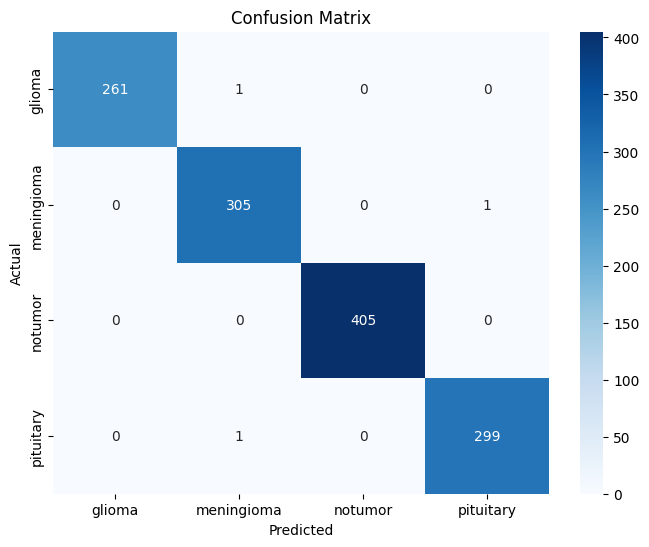

In [12]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

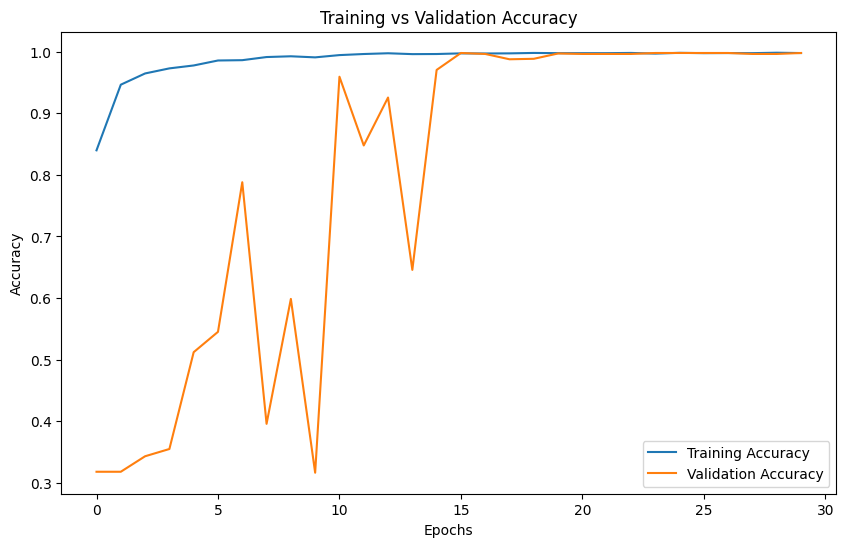

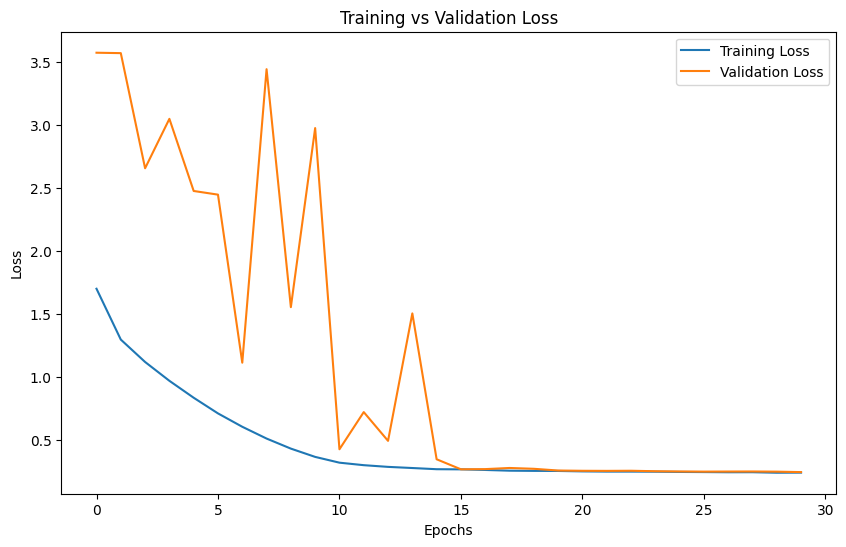

In [13]:
# Plot Training and Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

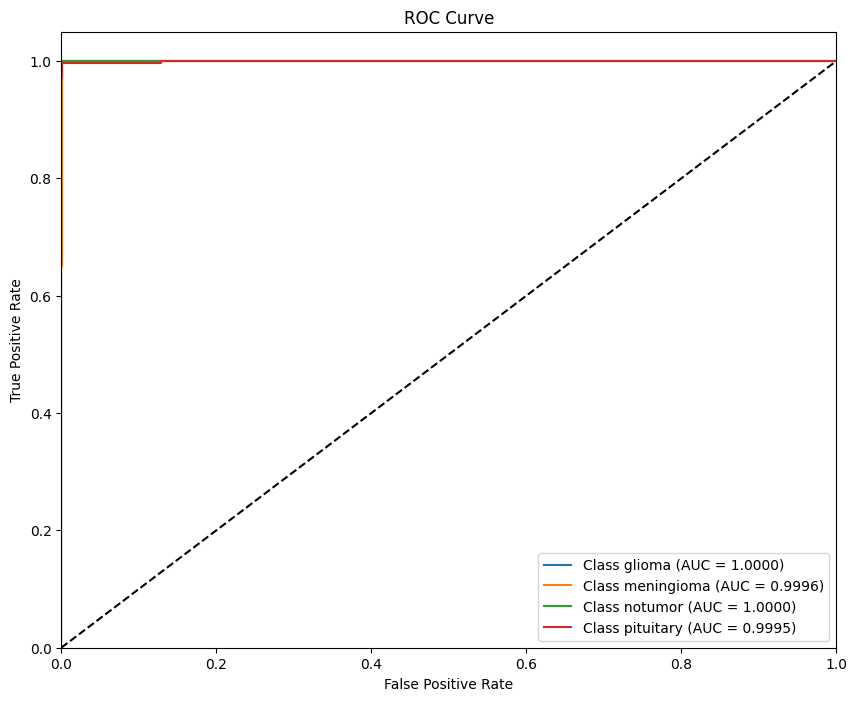

In [14]:
# ROC Curve for each class
plt.figure(figsize=(10, 8))
for i in range(4):
    fpr, tpr, _ = roc_curve(y_true == i, y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {target_names[i]} (AUC = {roc_auc:.4f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


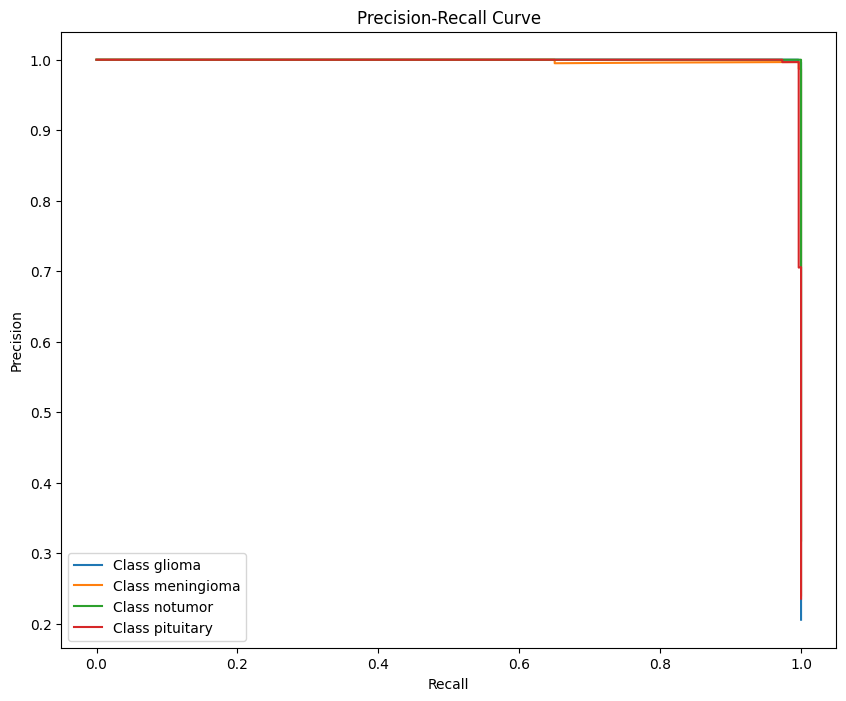

In [15]:
# Precision-Recall Curve for each class
plt.figure(figsize=(10, 8))
for i in range(4):
    precision, recall, _ = precision_recall_curve(y_true == i, y_pred[:, i])
    plt.plot(recall, precision, label=f'Class {target_names[i]}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

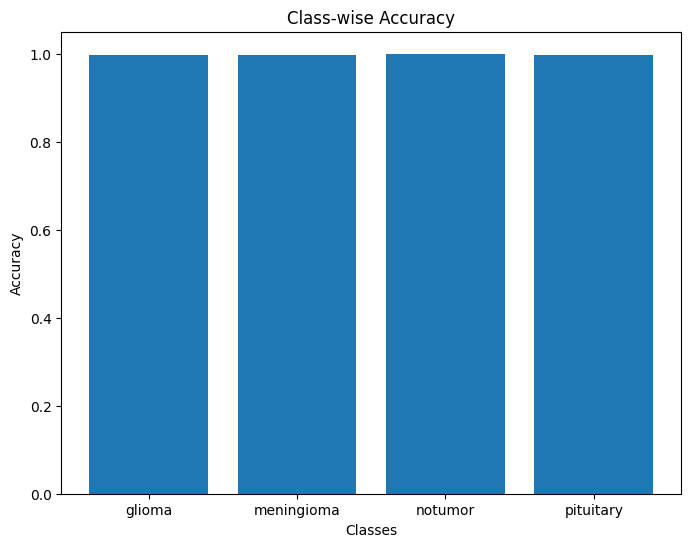

In [17]:
# Class-wise Accuracy Bar Plot
accuracy_per_class = cm.diagonal() / cm.sum(axis=1)
plt.figure(figsize=(8, 6))
plt.bar(target_names, accuracy_per_class)
plt.xlabel('Classes')
plt.ylabel('Accuracy')
plt.title('Class-wise Accuracy')
plt.show()


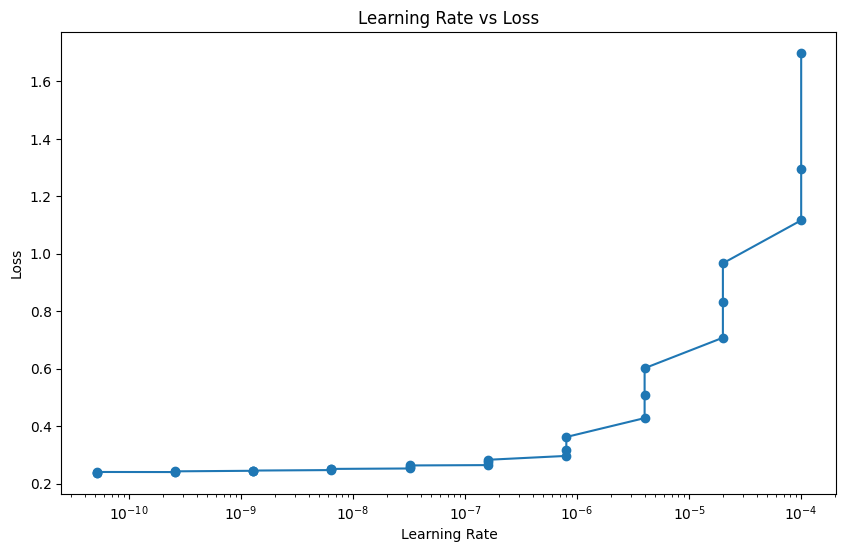

In [16]:
# Learning Rate vs Loss (Learning Rate Scheduler)
learning_rates = [0.0001 * (0.2 ** (i // 3)) for i in range(len(history.history['loss']))]
plt.figure(figsize=(10, 6))
plt.plot(learning_rates, history.history['loss'], marker='o')
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.xscale('log')
plt.title('Learning Rate vs Loss')
plt.show()

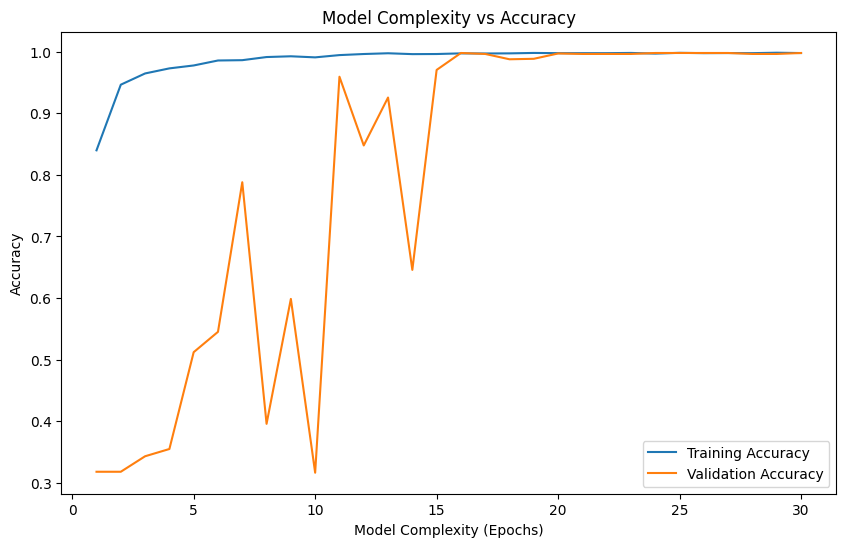

In [18]:
# Model Complexity vs Accuracy (Optional, depending on model complexity tracking)
plt.figure(figsize=(10, 6))
complexity = range(1, len(history.history['accuracy']) + 1)
plt.plot(complexity, history.history['accuracy'], label='Training Accuracy')
plt.plot(complexity, history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Model Complexity (Epochs)')
plt.ylabel('Accuracy')
plt.title('Model Complexity vs Accuracy')
plt.legend()
plt.show()